In [1]:
# NOTES

# Mind map
# https://miro.com/app/board/o9J_kwo5k8s=/

# Prediction labels
# [       0     ,      1    ,   2  ]
# ["pedestrian" , "bicycle" , "car"]

# Coordinate format: [longitude, latitude]

# Time format used:
# "%Y-%m-%dT%H:%M:%S.%fZ"

# Sequence format: Geojson
#     type
#     properties:
#       captured_at (start of sequence)
#       coordinateProperties
#         cas (camera angle between 0 and 360)
#         image_keys
#     geometry
#       coordinates [longitude, latitude]

# Image format: Geojson
#    type
#    properties:
#       captured_at, 
#       camera_model, camera_make, ca, pano, seq_key, key, username, user_key
#    geometry
    

# Potential features
#     Average velocity
#     Maximum velocity
#     Maximum stop time (calculate time between neighbours points relative to avg speed)
#     Possible to use CAS coordinate property to estimte slope and the difference in velocity?
#     Smallest turn (small turn will indicate not a car road)
#     Trajectory measurements
#     length
#     
#     
#     Image detection
#       Traffic lights (number or boolean)
#       Roundabouts (number or boolean)
#       Bicycle tracks on the side
#       Highway/number or lanes
#       Sidewalk


# Imports

In [6]:
# Imports
import json
import math
import requests
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
from pprint import pprint as pp
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from shapely.geometry import LineString, Point
import pandas as pd


# Utility functions

In [7]:
# Utility functions
def readJson(file):
    with open(file,"r") as f:
        rf=json.load(f)
    return rf

def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

def requestImagesBySequence(sequence_key):
    request = requests.get("https://a.mapillary.com/v3/images/?sequence_keys="+sequence_key+"&per_page=10000&client_id="+client_id)
    return request.json()

# Feature functions

In [8]:
# Functions
def avg_speed_n_forward(sequence, start,n):
    return 0

def height_calculations(images):
    request = ""
    data = []
    print(images)
    for im in images:
        data.append[im]
    return 0,0

def calc_sd(feat_list):
    mean = sum(feat_list)/len(feat_list)
    feat_list = list(map(lambda x: (x-mean)**2, feat_list))
    
    return np.sqrt(sum(feat_list)/len(feat_list))

def calc_mean_dist_median(_min, _max, speeds):
    median = (_max-_min)/2
    n = len(speeds)
    med_dist = lambda x: x-median
    dist = sum(list(map(med_dist,speeds)))/n
    return (_max-_min)/2

In [47]:
class Sequence:
    def __init__(self, sequence):
        #{type:"FeatureCollection",features:[{id,images},{id,images},...]
        self.id = sequence["id"]
        self.images = list(reversed(sequence["images"]))
        self.iterate()
    
    def iterate(self):
        if(not self.valid_sequence()):
            return 0
        # initial variables
        num_segments = len(self.images)-1
        dist = 0
        max_interval_dist = 0
        duration = 0
        max_speed = 0
        max_accel = 0
        num_stops = 0
        min_speed = 100000
        min_accel = 100000
        sum_speed = 0
        sum_accel = 0
        mean_relative_angle = 0
        speeds = []
        dist_start_end = self.distance(self.images[0]["geometry"]["coordinates"], self.images[-1]["geometry"]["coordinates"])
        
        prev = self.images[0]
        prev_speed = 0
        prev_bearing = 0
        
        percent_within = [0,0,0,0]
        
        for i,feat in enumerate(self.images[1:]):
            feat_dist = self.distance(prev["geometry"]["coordinates"], feat["geometry"]["coordinates"])
            feat_time = datetime.strptime(feat["properties"]["captured_at"], "%Y-%m-%dT%H:%M:%S.%fZ")
            prev_time = datetime.strptime(prev["properties"]["captured_at"], "%Y-%m-%dT%H:%M:%S.%fZ")
            feat_dur = abs(feat_time-prev_time).total_seconds()
            
            feat_bearing = self.get_bearing(prev["geometry"]["coordinates"],feat["geometry"]["coordinates"])
            
            feat_speed = 0 if feat_dur==0.0 else feat_dist/feat_dur
            feat_accel = prev_speed-feat_speed/feat_dur if feat_dur!=0.0 else 0
            
            percent_within[self.isWithinMeanSpeed(feat_speed)] += 1
            # speed features
            if(feat_speed<min_speed):
                min_speed = feat_speed
            if(feat_speed>max_speed):
                max_speed = feat_speed
            if(feat_speed<0.2):
                num_stops += 1
            # acceleration features
            if(feat_accel>max_accel and i>0):
                max_accel = feat_accel
            if(feat_accel<min_accel):
                min_accel = feat_accel
            if(feat_dist>max_interval_dist):
                max_interval_dist=feat_dist
            if(i>0):
                mean_relative_angle+=feat_bearing-prev_bearing
            speeds.append(feat_speed)
            sum_speed+=feat_speed
            sum_accel+=feat_accel
            
            
            dist+=feat_dist
            duration+=feat_dur
            prev = feat
            prev_bearing = feat_bearing
            prev_speed = feat_speed
            
        
        # Spatio-temporal, most of these are highly correlated
        self.avg_speed = dist/duration
        self.min_speed = min_speed
        self.max_speed = max_speed
        self.max_accel = max_accel
        self.max_deaccel = min_accel
        self.mean_dist_med_speed = calc_mean_dist_median(min_speed, max_speed, speeds)
        self.sd_speed = calc_sd(speeds)
        self.percent_ped_speed = 100*percent_within[0]/num_segments
        self.percent_bic_speed = 100*percent_within[1]/num_segments
        self.percent_car_speed = 100*percent_within[2]/num_segments
        self.num_stops = The 
        
        # Spatial features
        self.distance = dist
        self.msd = self.msd(list(map(lambda x:x["geometry"]["coordinates"], self.images)))
        self.sinuosity = dist/dist_start_end if dist_start_end!=0 else 100000
        self.turosity = max_interval_dist/dist
        self.convex_hull_area = self.convex_hull_area(np.array(list(map(lambda x:x["geometry"]["coordinates"],self.images))))
        if(not self.convex_hull_area):
            self.valid = False
        self.mean_relative_angle = mean_relative_angle/num_segments
        
        # Temporal
        self.duration = duration
            
    def get_feature_names(self):
        features = vars(self)
        excluded_keys = {"images","valid"}
        return [x for x in features if x not in excluded_keys]
    
    def get_features(self):
        features = vars(self)
        excluded_keys = {"images","valid"}
        return [features[x] for x in features if x not in excluded_keys]
    
    @staticmethod
    def convex_hull_area(points):
        try:
            hull = ConvexHull(points)
            return hull.area
        except:
            return False
    
    def get_bearing(self,p1,p2):
        deg2rad = self.deg2rad
        long1, lat1 = deg2rad(p1[0]),deg2rad(p1[1])
        long2, lat2 =  deg2rad(p2[0]),deg2rad(p2[1])
        dLon = (long2 - long1)
        
        y = math.sin(dLon) * math.cos(lat2)
        x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dLon)
        
        brng = math.atan2(y, x)        
        brng = np.rad2deg(brng)

        return brng
    
    def distance(self, start, end):
        deg2rad = self.deg2rad
        start = [deg2rad(start[0]),deg2rad(start[1])]
        end = [deg2rad(end[0]),deg2rad(end[1])]

        R =  6373000
        lon1, lat1, lon2, lat2 = start[0], start[1], end[0], end[1]
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = (math.sin(dlat/2)**2)+math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
        c = 2*math.atan2(math.sqrt(a), math.sqrt(1-a))
        return R*c
    
    def msd(self,points):
        X = list(map(lambda x: x[0],points))
        Y = list(map(lambda x: x[1],points))
        xdata = np.array(X)
        ydata = np.array(Y)
        r = np.sqrt(xdata**2 + ydata**2)
        diff = np.diff(r)
        diff_sq = diff**2
        MSD = np.mean(diff_sq)
        return MSD
    
    @staticmethod
    def deg2rad(deg):
        return deg*(math.pi/180)
    
    @staticmethod
    def isWithinMeanSpeed(speed):
        # From research in order to calculate the percentage of "within expected speeds"
        mean_ped_speed = 1.25
        mean_bic_speed = 5.3
        min_car_speed = 9.44
        sd_ped = 0.245
        sd_bic = 2
        if(abs(mean_ped_speed-speed)<sd_ped):
            return 0
        elif(abs(mean_bic_speed-speed)<sd_bic):
            return 1
        elif(speed>min_car_speed):
            return 2
        else:
            return 3

    def valid_sequence(self):
        # only want to keep trajectories with 2 or more coordinates
        if(len(self.images)<5):
            self.valid = False
            return False
        # some sequences have invalid durations, not including those
        start_t = datetime.strptime(self.images[0]["properties"]["captured_at"], "%Y-%m-%dT%H:%M:%S.%fZ")
        end_t = datetime.strptime(self.images[-1]["properties"]["captured_at"], "%Y-%m-%dT%H:%M:%S.%fZ")
        
        start_coord =self.images[0]["geometry"]["coordinates"]
        mid_coord = self.images[math.floor(len(self.images)/2)]["geometry"]["coordinates"]
        end_coord = self.images[-1]["geometry"]["coordinates"]
        
        if(start_t==end_t or (start_coord==mid_coord==end_coord)):
            self.valid = False
            return False
        self.valid = True
        return True
        
        
    def plot_trajectory(self):
        lat = list(map(lambda x:x["geometry"]["coordinates"][0], self.images))
        lng = list(map(lambda x:x["geometry"]["coordinates"][1], self.images))
        plt.plot(lat, lng, 'bo--', linewidth=2, markersize=6)
        plt.show()
    
    def plot_we(self, x,y):

        plt.plot(x, y, 'bo--', linewidth=2, markersize=6)
        plt.show()

['id',
 'avg_speed',
 'min_speed',
 'max_speed',
 'max_accel',
 'max_deaccel',
 'mean_dist_med_speed',
 'sd_speed',
 'percent_ped_speed',
 'percent_bic_speed',
 'percent_car_speed',
 'num_stops',
 'distance',
 'msd',
 'sinuosity',
 'turosity',
 'convex_hull_area',
 'mean_relative_angle',
 'duration']

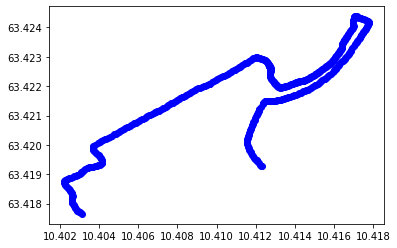

None

{'type': 'Feature',
 'properties': {'ca': 329.8442687988281,
  'camera_make': 'samsung',
  'camera_model': 'SM-G930F',
  'captured_at': '2018-08-25T14:01:26.165Z',
  'key': 'KGDdEnYLT2GF4J8TK3ibvw',
  'pano': False,
  'sequence_key': '8Qm0oG8BRzqv3b0A8yU67Q',
  'user_key': '_cYTqn8rPZFR_EvWHkf5cg',
  'username': 'pbb'},
 'geometry': {'type': 'Point', 'coordinates': [10.403101, 63.41765]}}

In [48]:
self = Sequence(data["features"][140])
display(self.get_feature_names())
display(self.plot_trajectory())
self.mean_dist_med_speed, self.avg_speed
self.images[0]

In [37]:
# write features for an area
def area_features(data, f_loc="training_data/features.csv", write=False, stop_early=False, sample_size=20):
    num_seq = len(data["features"])
    print(f"[INFO] {num_seq} sequences:")
    label_names = (",").join(Sequence(data["features"][0]).get_feature_names()[1:])+",id\n"
    f = open(f_loc, "w+")
    written = 0
    if(write==True):
        f.write(label_names)
    for num, seq in enumerate(data["features"]):
        if(stop_early==True and num>sample_size-1):
            break
        printProgressBar(num, num_seq)
        seq = Sequence(seq)
        if(not seq.valid):
            continue
        if(write==True):
            written+=1
            s = ""
            features = seq.get_features()
            for feat in features[1:]:
                s += f"{feat},"
            f.write(f"{s}{features[0]}\n")
    f.close()
    print(f"[INFO] Done generating features. Written: {written}")

In [38]:
data = readJson("mapillary_data/mapillary_data_no_dupes.json")

In [39]:
area_features(data, f_loc="training_data/features_no_dupes.csv",stop_early=False, write=True)

[INFO] 2327 sequences:
[INFO] Done generating features. Written: 1863███████████████████████████████████████████████████████-| 100.0% 
